In [1]:
# uncomment the last two cell to clone the data and enable the GPU
#! git clone https://github.com/ParsProgrammer/ERS.git

In [2]:
#cd ERS

# **Packages**

In [1]:
%pip install tensorflow-gpu==2.9
%pip install tensorflow-text

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import tensorflow_text as tf_text

In [3]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import gzip
import gc
import numpy as np
from tensorflow import keras
from sklearn.model_selection import KFold
import datetime 
import os
import matplotlib.pyplot as plt


In [5]:
%pip install gensim==4.2
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api
from nltk.tokenize import sent_tokenize, word_tokenize


In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mobin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else :
  print("No GPU available")

2023-01-11 10:53:17.393157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 10:53:17.410993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 10:53:17.411219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 10:53:17.411988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

1 Physical GPUs, 1 Logical GPUs


In [9]:
%pip install tensorboard
%pip install -U tensorboard_plugin_profile

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
from multiprocessing import Pool

# **Data Extraction**

In [11]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    name=b'"verified": \"true\",'
    l=l.replace(b'"verified": true,',bytes(name))
    name1=b'"verified": \"false\",'
    l=l.replace(b'"verified": false,',bytes(name))
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Grocery_and_Gourmet_Food_5.json.gz')

# dataset link
# Grocery and Gourmet Food
# https://jmcauley.ucsd.edu/data/amazon/

In [12]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013"
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014"
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013"
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013"
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013"
...,...,...,...,...,...,...,...,...,...
151249,A2L6QS8SVHT9RG,B00KCJRVO2,"randomartco ""period film aficionado""","[0, 0]",Delicious gluten-free oatmeal: we tried both t...,4.0,Delicious gluten-free oatmeal 'quick' packs!,1405123200,"07 12, 2014"
151250,AFJFXN42RZ3G2,B00KCJRVO2,"R. DelParto ""Rose2""","[0, 0]",With the many selections of instant oatmeal ce...,4.0,Convenient and Instant,1404604800,"07 6, 2014"
151251,ASEBX8TBYWQWA,B00KCJRVO2,"Steven I. Ramm ""Steve Ramm &#34;Anything Phon...","[1, 1]","While I usually review CDs and DVDs, as well a...",5.0,Compares favorably in taste and texture with o...,1404172800,"07 1, 2014"
151252,ANKQGTXHREOI5,B00KCJRVO2,Titanium Lili,"[0, 1]",My son and I enjoyed these oatmeal packets. H...,4.0,Pretty good!,1404432000,"07 4, 2014"


Dataset Schema

In [13]:
df.rename(columns={"reviewerID": "userID", "asin": "itemID","overall":"rating"},inplace=True)
df=df[['userID','itemID','reviewText','rating']]
df

,userID,itemID,reviewText,rating
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4.0
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3.0
2,A27IQHDZFQFNGG,616719923X,Really good. Great gift for any fan of green t...,4.0
3,A31QY5TASILE89,616719923X,"I had never had it before, was curious to see ...",5.0
4,A2LWK003FFMCI5,616719923X,I've been looking forward to trying these afte...,4.0
...,...,...,...,...
151249,A2L6QS8SVHT9RG,B00KCJRVO2,Delicious gluten-free oatmeal: we tried both t...,4.0
151250,AFJFXN42RZ3G2,B00KCJRVO2,With the many selections of instant oatmeal ce...,4.0
151251,ASEBX8TBYWQWA,B00KCJRVO2,"While I usually review CDs and DVDs, as well a...",5.0
151252,ANKQGTXHREOI5,B00KCJRVO2,My son and I enjoyed these oatmeal packets. H...,4.0


In [14]:
df.sample(10)

,userID,itemID,reviewText,rating
100410,ALL9XFM0Q1N4E,B004JLQ6UE,These were a great tasting drink. Some were be...,4.0
42512,AYUENZW96SXTM,B0019ZHU2Q,I have these of my subscribe and save! LOVE TH...,5.0
150510,AX9C10JD538D9,B00HHFWJS2,"I live alone, so I like meals that I can make ...",4.0
146174,A1Z0LTKUA6F94D,B00DMSHM30,If you like the flavors in this pack and need ...,3.0
114989,A2E7RX6AFUDQEX,B005HG9ERW,"I'm not quite sure how to explain this, becaus...",5.0
107987,A2AKRD5PK5PQ14,B004VLVJ9U,"This is probably the best tasting, easiest to ...",5.0
85989,AFICF7DKHTQ87,B003TN6ZN6,My baby has no issues with this formula milk e...,4.0
75256,ALAN629D6EKQZ,B002T5TMWG,Fast shipping as always. Big chucks of sardin...,5.0
83703,A4EWLZLUCY5QR,B003LJW68G,i bought this pasta after reading the reviews ...,5.0
131960,A1GNYV0RA0EQSS,B008I1XLDQ,I enjoyed sampling all of the different K-Cups...,4.0


# **Data Analysis**

**User Data**

determining all unique users with their reviews and ratings

In [15]:
user_df=df[['userID','reviewText','rating']].groupby('userID')['rating','reviewText'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
user_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,userID,reviewText,rating
0,A00177463W0XWB16A9O05,[It is a good stand by coffee you can count on...,"[5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 5.0, ..."
1,A022899328A0QROR32DCT,[awesome texture for even the gluten eating ea...,"[5.0, 1.0, 4.0, 5.0, 5.0, 5.0, 1.0, 2.0, 3.0, ..."
2,A04309042SDSL8YX2HRR7,[I love roasted garlic & sweet bell peppers. Y...,"[5.0, 2.0, 4.0, 4.0, 4.0]"
3,A068255029AHTHDXZURNU,[These bars are especially delicious for cocon...,"[5.0, 5.0, 3.0, 5.0, 3.0, 3.0, 5.0, 5.0, 5.0]"
4,A06944662TFWOKKV4GJKX,[UGH! My stomach has been really killing me l...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
...,...,...,...
14676,AZWRZZAMX90VT,"[Very nice. Not spicy, not too salty, lots of ...","[5.0, 5.0, 2.0, 5.0, 5.0, 4.0, 4.0, 3.0, 4.0, ..."
14677,AZXKAH2DE6C8A,[Could not imagine having such a rich tasting ...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, ..."
14678,AZXON596A1VXC,[I was a bit skeptical when I bought this prod...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
14679,AZYXC63SS008M,[This is just about the healthiest you can get...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"


**Item Data**

determining all unique items with their reviews and ratings

In [16]:
item_df=df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
item_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,itemID,reviewText,rating
0,616719923X,[Just another flavor of Kit Kat but the taste ...,"[4.0, 3.0, 4.0, 5.0, 4.0, 4.0, 3.0, 5.0, 5.0, ..."
1,9742356831,[This curry paste makes a delicious curry. I ...,"[5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
2,B00004S1C5,[These dyes create awesome colors for kids cra...,"[5.0, 1.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
3,B0000531B7,[I really enjoy these bars as a quick breakfas...,"[5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0]"
4,B00005344V,"[Traditional Medicinals' ""Breathe Easy"" is an ...","[5.0, 3.0, 5.0, 5.0, 3.0, 5.0, 5.0]"
...,...,...,...
8708,B00JGPG60I,[We switched to this formula 5 days ago and fo...,"[4.0, 4.0, 4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, ..."
8709,B00JL6LTMW,[We have enjoyed Larabar's variety of bars for...,"[4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, ..."
8710,B00K00H9I6,[This 100% pure Canadian maple syrup is a Grad...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
8711,B00KC0LGI8,[I followed the directions on the box exactly ...,"[2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 2.0, 5.0, 3.0, ..."


In [17]:
# dataset minimization
if os.path.exists("raw_data.csv"):
    df = pd.read_csv('raw_data.csv')
else :  
    sample_userID = list( user_df[user_df['reviewText'].apply(lambda x : len(x)> 80 )].sample(51)['userID'])
    new_df = df[ df['userID'].isin(sample_userID)]
    item_ddf = new_df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
    sample_itemID = list( item_ddf[ item_ddf['reviewText'].apply(lambda x : len(x)>4)]['itemID'] )
    df = new_df[new_df['itemID'].isin(sample_itemID)].reset_index(drop=True).sample(frac=1)
    df.to_csv('raw_data.csv')

user_df=df[['userID','reviewText','rating']].groupby('userID')['rating','reviewText'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
item_df=df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()


/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == "":
/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


In [18]:
print("review num : ", df.shape[0] ,"user num : " ,user_df.shape[0],"item num : ",item_df.shape[0] )

review num :  1994 user num :  51 item num :  200


##   Ratings

count    1994.000000
mean        3.953862
std         1.026922
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

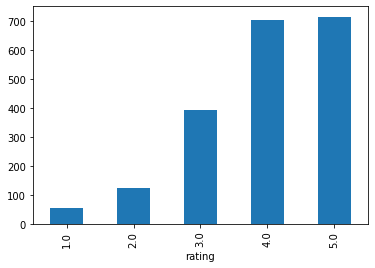

In [19]:
df.groupby('rating').size().plot(kind="bar");
df['rating'].describe()
#histogram of ratings

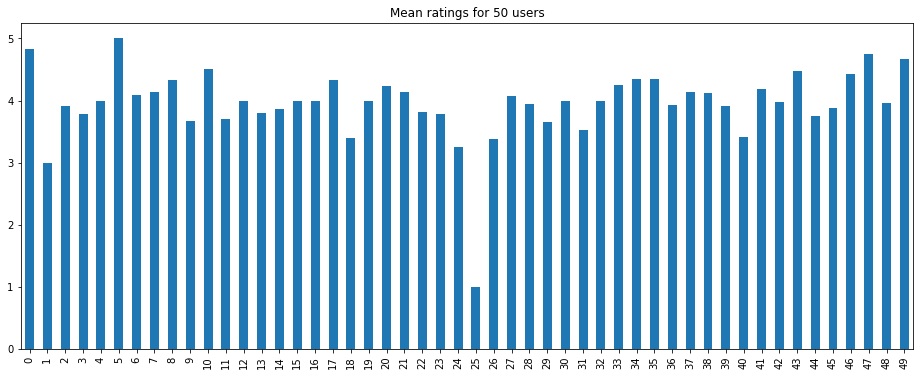

In [20]:
user_means=user_df.rating.apply(lambda x: np.mean(x))
user_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 users");

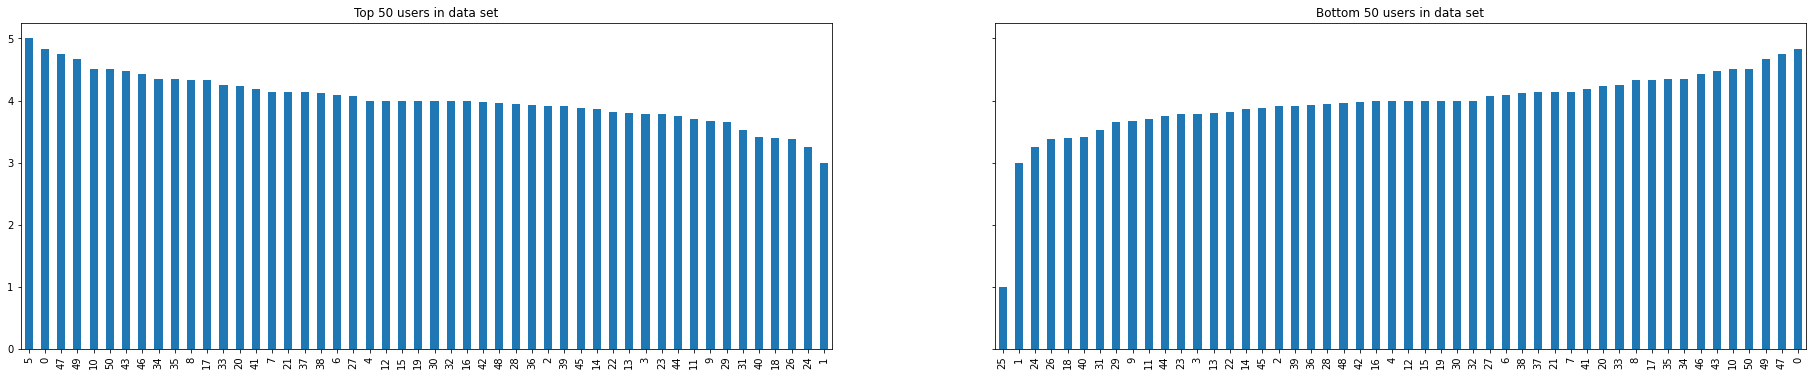

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
user_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 users in data set")
user_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 users in data set");

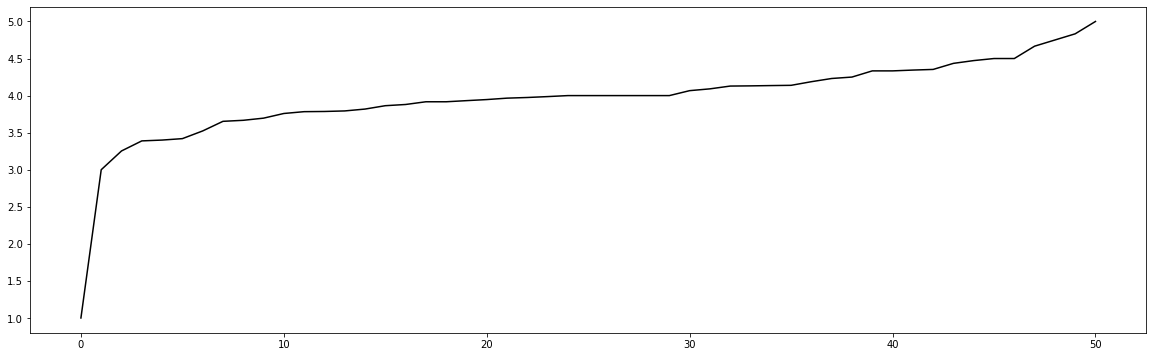

In [22]:
user_means = df.groupby("userID").rating.mean().sort_values()
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")


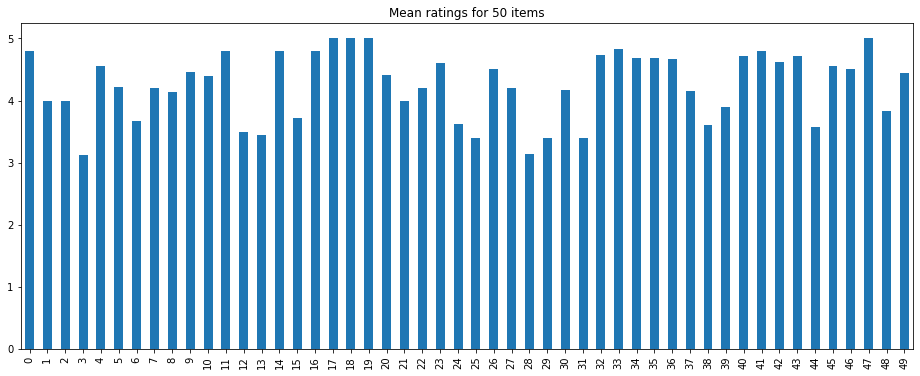

In [23]:
item_means=item_df.rating.apply(lambda x: np.mean(x))
item_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 items");

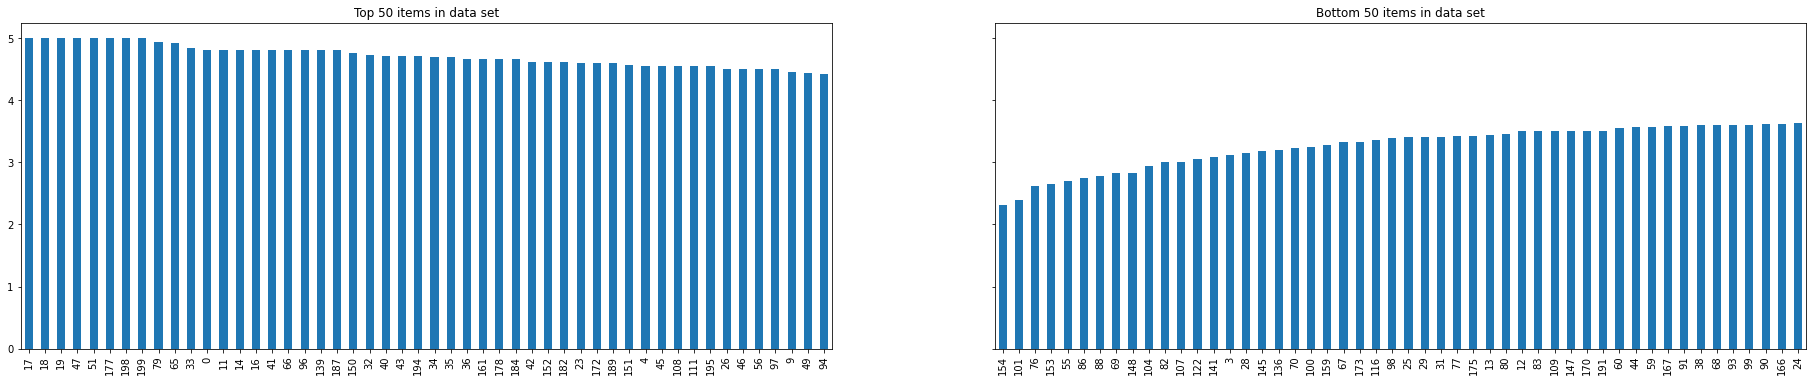

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
item_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 items in data set")
item_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 items in data set");

## Reviews

In [25]:
df['reviewText'].describe()

count                                                  1994
unique                                                 1994
top       The soup I tried was the red pepper with Gouda...
freq                                                      1
Name: reviewText, dtype: object

count    1994.000000
mean      737.340522
std       502.430526
min        78.000000
25%       428.000000
50%       608.000000
75%       881.750000
max      8136.000000
Name: reviewText, dtype: float64

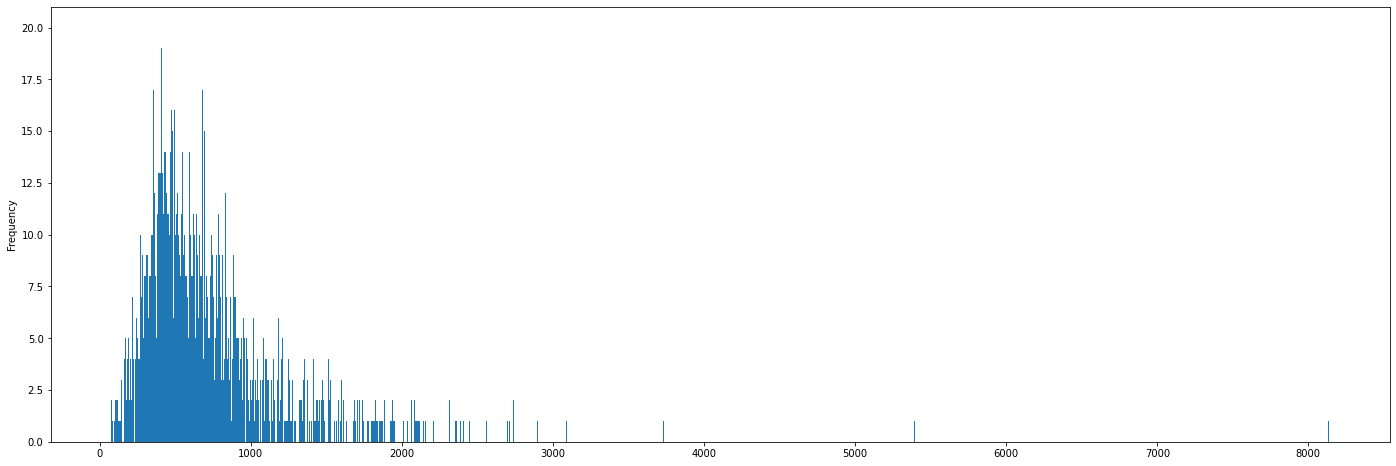

In [26]:
# review length
rv_le=df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()


In [27]:
sum=0
sum2=0
for x in user_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(user_df['reviewText'])
w_mean=sum2/(r_mean*len(user_df['reviewText']))
print('mean of reviews per user:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per user:',r_mean * w_mean)
# plot for reviews per user

mean of reviews per user: 39.09803921568628
mean of words per review: 737.340521564694
mean of words per user: 28828.56862745098


In [28]:
a=item_df['reviewText'].apply(len)
a[a>40]

Series([], Name: reviewText, dtype: int64)

count    200.000000
mean       9.970000
std        4.697813
min        5.000000
25%        6.000000
50%        9.000000
75%       13.000000
max       31.000000
Name: reviewText, dtype: float64

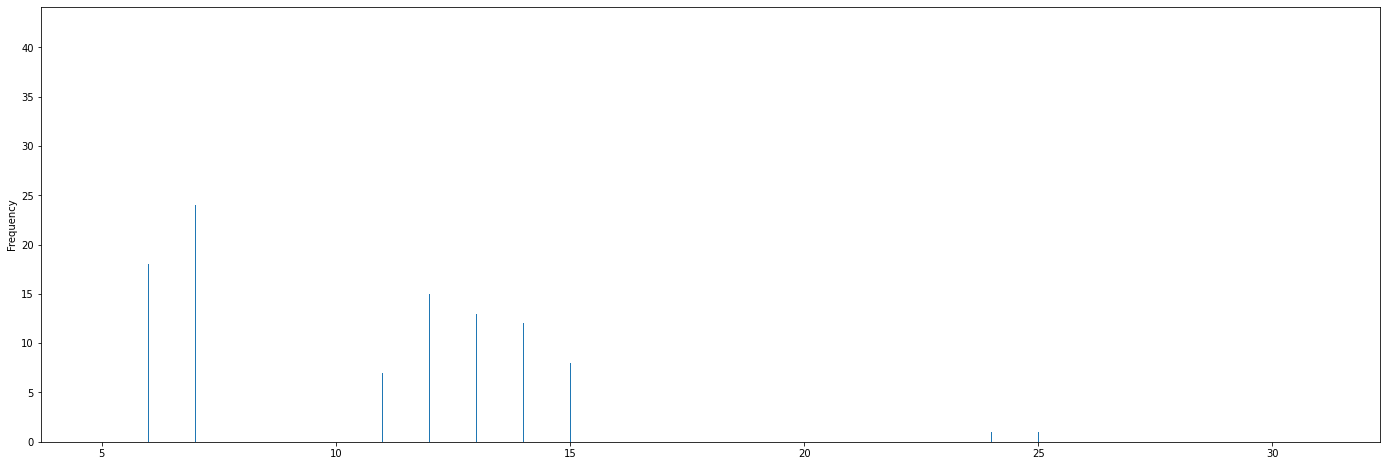

In [29]:
rv_le=item_df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()

count     51.000000
mean      39.098039
std       30.925236
min        1.000000
25%       13.500000
50%       33.000000
75%       63.500000
max      117.000000
Name: reviewText, dtype: float64

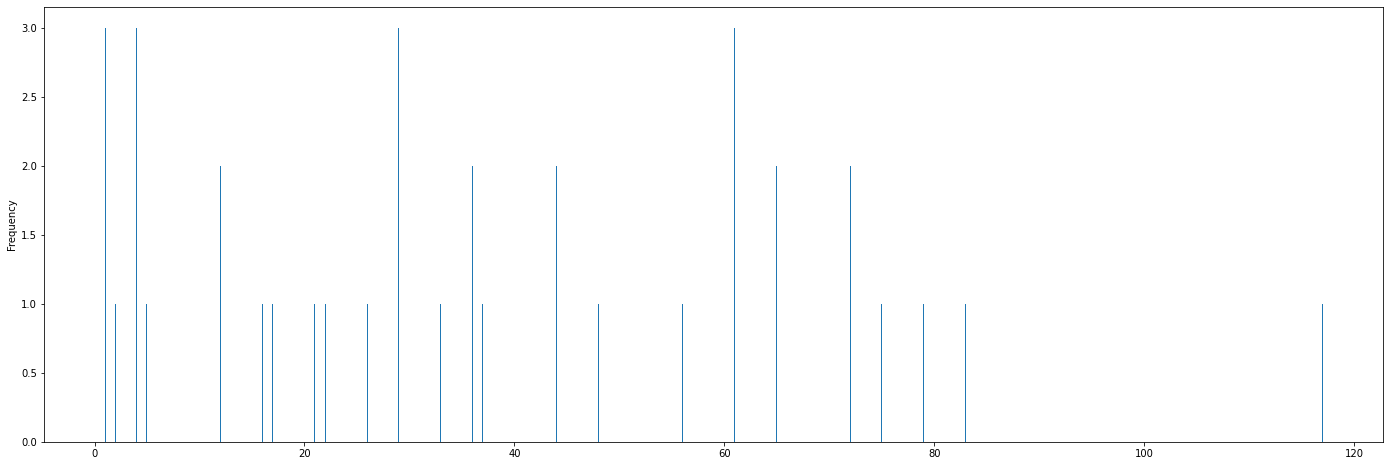

In [30]:
rv_le=user_df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()

In [31]:
sum=0
sum2=0
for x in item_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(item_df['reviewText'])
w_mean=sum2/(r_mean*len(item_df['reviewText']))
print('mean of reviews per item:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per item:',r_mean * w_mean)

mean of reviews per item: 9.97
mean of words per review: 737.340521564694
mean of words per item: 7351.284999999999


# **Data Splitting**

In [32]:
if os.path.exists("train_df.csv") & os.path.exists("test_df.csv"):
        train_df = pd.read_csv('train_df.csv')
        test_df = pd.read_csv('test_df.csv')

else:
    current_fold=10
    kfold = KFold(10)
    random_iterator=kfold.split(df)
    for i in range(current_fold):
      train_index, test_index = next(random_iterator, None)
      print(train_index,len(train_index))
      train_df, test_df =df.iloc[train_index], df.iloc[test_index]
    train_df.to_csv('train_df.csv')
    test_df.to_csv('test_df.csv')
    

In [33]:
train_df

,Unnamed: 0,userID,itemID,reviewText,rating
0,1161,A2V92F5R7MLCVI,B0096RP84Q,The soup I tried was the red pepper with Gouda...,2.0
1,1974,A1UQBFCERIP7VJ,B00H7282WW,This particular variety of Kernel Season's pop...,4.0
2,876,A1UQBFCERIP7VJ,B006J4MAHW,Nature's Path Organic Love Crunch is a rolled-...,4.0
3,1517,A3NHUQ33CFH3VM,B00BDFNRG0,I don't dislike this popcorn as much as the re...,2.0
4,589,A2V92F5R7MLCVI,B004GWRP1A,This pasta is perfect for those of you who mak...,5.0
...,...,...,...,...,...
1790,1566,A1UQBFCERIP7VJ,B00BJH5A26,Gratify Gluten Free Pretzel Twists are just li...,5.0
1791,1370,A3NHUQ33CFH3VM,B00A4ASPXU,I attribute the slightly odd taste to the flav...,4.0
1792,402,A1ZPY91VE3IDN1,B003EXVM4S,"I grew up on Mueller's pasta, the blue box, wh...",4.0
1793,1935,A1KEK09ZA6J9P8,B00GLP9JI2,I often purchase drink add-ins to make my wate...,4.0


# **Embedding Matrix**

In [34]:
# hyperparameters
embedding_dim=300
min_frequent_word_num=1
max_vocab_size=3000
sequence_length=18
document_length=20

In [35]:
def tf_lower_and_split_punct(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text= tf.strings.reduce_join( tf.strings.split(text)[:,:sequence_length-2],axis=-1,separator=' ')
  return  text.numpy()

In [36]:
with tf.device('/CPU:0'):
    user_corpus =list(map(tf_lower_and_split_punct,user_df['reviewText'])) 
    item_corpus = list( map(tf_lower_and_split_punct,item_df['reviewText']) )

In [37]:
def load_word2vec_model():
    if os.path.exists("word2vec.wordvectors"):
        print("loaded from word2vec.wordvectors")
        return KeyedVectors.load("word2vec.wordvectors",mmap='r')
    else:
        # downloading google news word2vec model
        if not os.path.exists("word2vec_google.bin"):
            downloaded_model = api.load('word2vec-google-news-300')
            downloaded_model.save_word2vec_format('word2vec_google.bin',binary=True)
            del downloaded_model
        # loading google news word2vec model
        google_word2vec = KeyedVectors.load_word2vec_format("word2vec_google.bin", binary=True)

       # tokenizing the whole reviews in text_corpus
        text_corpus=[]
        for i,doc in enumerate(user_corpus):    # iterate through each sentence in the reviews
            for rv in doc:
                for sen in sent_tokenize(rv.decode("utf-8")):
                    temp = []
                    # tokenize the sentence into words          
                    for j in word_tokenize(sen):
                        temp.append(j.lower())
                    text_corpus.append(temp)
                    del temp


        # creating a new word2vec model and initializing it from pretrained google_word2vec
        word2vec_model=Word2Vec( text_corpus,max_final_vocab=max_vocab_size,min_count=min_frequent_word_num ,vector_size= embedding_dim,window = 5,workers=16, sg=1,epochs=1)
        word2vec_model.build_vocab(text_corpus)

        word2vec_model.build_vocab([google_word2vec.index_to_key],update=True)
        word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv))
        word2vec_model.wv.intersect_word2vec_format("word2vec_google.bin",binary=True,lockf=1.0)
        
        # fine tuning the model and saving it
        word2vec_model.train(text_corpus, epochs=5, total_examples=word2vec_model.corpus_count)
        word2vec_model.wv.save("word2vec.wordvectors")
        
        del google_word2vec
        del text_corpus[:]
        gc.collect()
  
        return word2vec_model.wv
        

In [38]:
# loading the embedding lookup matrix shape=( 30k ,300 ) approximately
embedding_matrix = load_word2vec_model() 
print( "embedding matrix shape : (",len(embedding_matrix.index_to_key)," ,",embedding_matrix.vector_size,")")

embedding matrix shape : ( 1667  , 300 )


In [39]:
embedding_matrix.index_to_key

['i',
 '.',
 ',',
 'the',
 'a',
 'this',
 'and',
 'of',
 'is',
 'to',
 'it',
 'in',
 'these',
 'are',
 'that',
 'for',
 'but',
 'my',
 'with',
 'like',
 'was',
 'have',
 'tea',
 'not',
 'good',
 'flavor',
 'as',
 'has',
 'you',
 'love',
 'really',
 'so',
 'very',
 'taste',
 'on',
 'pasta',
 'they',
 'tried',
 'ive',
 'when',
 'one',
 'if',
 'its',
 'im',
 'be',
 'just',
 'coffee',
 'from',
 'had',
 'all',
 'side',
 'can',
 'we',
 'at',
 'great',
 'or',
 'water',
 'rice',
 'barilla',
 'drink',
 'product',
 'an',
 'cookies',
 'couscous',
 '!',
 'chocolate',
 'first',
 'easy',
 'tasty',
 'nice',
 'more',
 'been',
 'sweet',
 'me',
 'mix',
 'little',
 'than',
 'sauce',
 'much',
 'about',
 'make',
 'used',
 'delicious',
 'use',
 'what',
 'box',
 'no',
 'crackers',
 'some',
 'out',
 'because',
 'were',
 'tastes',
 'fan',
 'there',
 'sugar',
 'always',
 'do',
 'would',
 'bit',
 'them',
 'free',
 'green',
 'lipton',
 'quite',
 'am',
 'energy',
 'pretty',
 'up',
 'too',
 'other',
 'seasoning',
 

In [40]:
# vocab_size is equal to full_embedding_matrix shape[0]
special_token_embedding = np.random.rand(4,embedding_matrix.vector_size)
full_embedding_matrix = np.concatenate((special_token_embedding,embedding_matrix.vectors))
full_embedding_matrix.shape

(1671, 300)

In [41]:
# example
# embedding_matrix['keep']

# **Text Vectorization**

In [42]:
# hyperparameter

batch_size = 32 # for seq2seq model
batch_size_test = 32 # for seq2seq model
num_batches=int(train_df.shape[0]/batch_size)
num_batches_test=int(test_df.shape[0]/batch_size_test)
print("number of batches in train data",num_batches)
print("number of batches in test data",num_batches_test)

number of batches in train data 56
number of batches in test data 6


## **Preprocessing**

In [43]:
def tf_lower_and_split_punct_enc(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text


def tf_lower_and_split_punct_decin(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text], separator=' ') 
  return text


def tf_lower_and_split_punct_decout(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join([ text, '[END]'], separator=' ')
  return text



## Vectorization layer

- The conversion of tokens to ids

In [44]:
enc_input_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_enc,
                                                     output_sequence_length = sequence_length,  )
dec_input_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_decin,
                                                     output_sequence_length = sequence_length,  )

dec_output_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_decout,
                                                     output_sequence_length = sequence_length,  )

In [45]:
enc_input_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )
dec_input_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )
dec_output_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )

In [48]:
print(enc_input_processor.get_vocabulary().index('come'))
print(enc_input_processor.get_vocabulary()[351])

266
italian


In [49]:
# included sos, eos, unk and space 
print("input_text_processor vocab size :" ,len(enc_input_processor.get_vocabulary()))
# Here are the first 16 words from the vocabulary:
print(enc_input_processor.get_vocabulary()[:16])
print(df['reviewText'][0][:300])
print(dec_output_processor(  df['reviewText'][0]))

input_text_processor vocab size : 1671
['', '[UNK]', '[START]', '[END]', 'i', '.', ',', 'the', 'a', 'this', 'and', 'of', 'is', 'to', 'it', 'in']
The soup I tried was the red pepper with Gouda. The taste was basically very good and then came the exceptions. After a few spoonfuls I had something unidentifiable - hard in my mouth. This happened twice. I still cannot figure out what it was. It was the size of a piece of uncooked rice, but no ric
tf.Tensor(
[   7  246    4   41   24    7  400  728   22 1198    5    7   37   24
 1146   36   28   10], shape=(18,), dtype=int64)


# **TF-IDF Matrix**

In [50]:
with tf.device('/CPU:0'):

  tfidf_calculator = tf.keras.layers.TextVectorization(
    max_tokens  = max_vocab_size,
    output_mode ='tf-idf',
    pad_to_max_tokens = True  
    )
  tfidf_calculator.adapt(enc_input_processor.get_vocabulary()[:] )
  print("the length of tf-idf vocab",len(tfidf_calculator.get_vocabulary()))
  print( list(set(enc_input_processor.get_vocabulary())-set(tfidf_calculator.get_vocabulary()))[:9])
  print( list(set(embedding_matrix.index_to_key)-set(tfidf_calculator.get_vocabulary()))[:9])


the length of tf-idf vocab 1665
['', '?', ',', '[START]', '[END]', '!', '.']
[',', '?', '.', '!']


In [51]:
# with tf.device('/CPU:0'):

#     user_tfidf = list( map(tfidf_calculator, user_corpus))
#     item_tfidf = list( map(tfidf_calculator, item_corpus))


# **Forming Dataset**

In [52]:
# convert string id to int id
user_to_row = {}
item_to_column = {}

for i, user_id in enumerate(np.unique(df['userID'])):
    user_to_row[user_id] = i

for j, item_id in enumerate(np.unique(df['itemID'].tolist())):
    item_to_column[item_id] = j

In [53]:
train_ds_seq = tf.data.Dataset.from_tensor_slices(
    (
       [user_to_row[dp] for dp in df['userID']],
       [item_to_column[dp] for dp in df['itemID']],
       tf.cast(dec_input_processor(df['reviewText']),dtype=tf.int32),
       tf.cast(dec_output_processor(df['reviewText']),dtype=tf.int32)       
    )
).shuffle(131072).batch(batch_size,drop_remainder=True)
# test_ds_seq = tf.data.Dataset.from_tensor_slices(
#     (
#       [user_to_row[dp] for dp in test_df['userID']],
#       [item_to_column[dp] for dp in test_df['itemID']],
#       tf.cast(dec_input_processor(test_df['reviewText']),dtype=tf.int32),
#       tf.cast(dec_output_processor(test_df['reviewText']),dtype=tf.int32)         
#     )
# ).shuffle(16384).batch(batch_size_test,drop_remainder=True)

train_ds_pmf = tf.data.Dataset.from_tensor_slices(
    (
       [user_to_row[dp] for dp in train_df['userID']],
       [item_to_column[dp] for dp in train_df['itemID']],
       tf.cast(train_df['rating'],dtype=tf.float16)
    )
).shuffle(131072).batch(1024)
test_ds_pmf = tf.data.Dataset.from_tensor_slices(
    (
      [user_to_row[dp] for dp in test_df['userID']],
      [item_to_column[dp] for dp in test_df['itemID']],
      tf.cast(test_df['rating'],dtype=tf.float16)
    )
).shuffle(16384).batch(64)

In [54]:
train_data_num=train_df.shape[0]
test_data_num=test_df.shape[0]
print("train and test data number : ",train_data_num," , ",test_data_num)

train and test data number :  1795  ,  199


# **User and Item Documents**

**User Documents**

In [55]:
user_doc = list( map(enc_input_processor,[doc[:document_length] for doc in user_df['reviewText']]))

**Item Documents**

In [56]:
item_doc = list( map(enc_input_processor,[doc[:document_length] for doc in item_df['reviewText']]))

Text(0.5, 1.0, 'Mask')

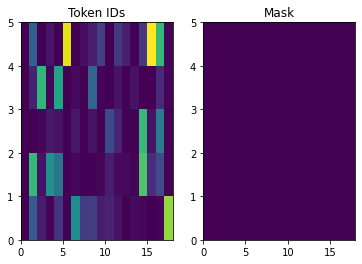

In [57]:
plt.subplot(1, 2, 1)
plt.pcolormesh(item_doc[0])
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(item_doc[0] != 0)
plt.title('Mask')

### Converting ID to Vector

In [58]:
user_df['reviewText'][0][0]

"A nutritionist recommended this cereal to me. It is high in protein and whole grains. It provides 20% of your daily protein and 40% of fiber. Some stats on it:- Non-GMO Project Verified- 9g Protein- 8g Fiber- 3g Fat per serving- 16g of Whole GrainsFor 3/4 cup, it is 190 calories and it has 13g of sugar.  The nutrition recommends to staying to 8g or under of sugar in cereal in general.  There is no actual sugar in the cereal, but there is cane syrup.  Ingredients include: Kashi Seven Whole Grains And Sesame Blend (Whole: Hard Red Wheat, Brown Rice, Barley, Triticale, Oats, Rye, Buckwheat, Sesame Seeds), Soy Flakes, Brown Rice Syrup, Dried Cane Syrup, Chicory Root Fiber, Whole Grain Oats, Expeller Pressed Canola Oil, Honey, Salt, Cinnamon, Mixed Tocopherols For Freshness.I wouldn't eat it every day as I try to keep my sugar low, but it's great when you want a crunchy and tasty treat for breakfast which fills you up."

In [59]:
input_vocab = enc_input_processor.get_vocabulary()
" ".join([input_vocab[id] for id in user_doc[0][0]])


'[START] a nutritionist recommended this cereal to me . it is high in protein and whole grains .'

# **Metrics**

In [60]:
# log files for training and test
train_log_dir = 'logs/'  + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
adv_train_log_dir = 'logs/'  + '/adv_train'
adv_train_summary_writer = tf.summary.create_file_writer(adv_train_log_dir)
test_log_dir = 'logs/'  + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
graph_log_dir = 'logs/graph/'  
graph_summary_writer = tf.summary.create_file_writer(graph_log_dir)

In [61]:
class PerplexityMetric(tf.keras.metrics.Metric):
    def __init__(self,name='perplexity',**kwargs):
        super().__init__(name=name, **kwargs)
        self.perplexity=self.add_weight(name='pl',initializer='zeros')

    def update_state(self, nll_loss):
        self.perplexity= 2 ** nll_loss

    def result(self):
        return self.perplexity

        
class MSE(tf.keras.metrics.Metric):
    def __init__(self,name='MSE',**kwargs):
        super().__init__(name=name, **kwargs)
        self.mse=self.add_weight(name='mse',initializer='zeros')

    def update_state(self,mse):
        self.mse =  mse

    def result(self):
        return self.mse


In [62]:

train_plx_gen_tch = PerplexityMetric(name='train teacher forcing perplexity')  # teacher forcing mode
train_plx_gen_plc = PerplexityMetric(name='train policy gradient perplexity')  # policy gradient mode
test_plx_gen = PerplexityMetric(name='test perplexity')  
train_acc_dis = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
train_mse = MSE(name='trian mse')
test_mse = MSE(name='test mse')

# **Context-aware Matrix Factorization for Rating Prediction**

In [63]:
#hyperparameters
num_users=len(user_to_row)
num_items=len(item_to_column)
mean_inv = np.float32( train_df['rating'].mean())



In [64]:
# hyperparameters
feature_num=128 # number of topics
units=int(feature_num/2 )# gru units

In [65]:
# del df
# del user_df
# del item_df
# del user_corpus[:]
# del item_corpus[:]
# del train_df
# del test_df

# gc.collect()
# gc.collect(0)
# gc.collect(1)
# gc.collect(2)

## **PMF (Probabilistic Matrix Factorization)**

In [66]:
class PMF():
    def __init__(self, num_feat=16, epsilon=1, _lambda=0.2, momentum=0.8,  batch_size=1024,num_item=9000,num_user=15000,mean_inv=3.00000):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.num_item=num_item
        self.num_user=num_user
        self.V =  0.1 * np.random.randn(self.num_item, self.num_feat).astype(np.float64)  # Item feature vectors
        self.U =  0.1 * np.random.randn(self.num_user, self.num_feat).astype(np.float64)  # User feature vectors
        self.V_inc = np.zeros((self.num_item, self.num_feat),dtype=np.float64)
        self.U_inc = np.zeros((self.num_user, self.num_feat),dtype=np.float64)
        self.mean_inv= mean_inv  
        
        self.user_textual_features = np.zeros(shape=(num_users, feature_num),dtype=np.float32 )
        self.item_textual_features =  np.zeros(shape=(num_items, feature_num),dtype=np.float32)
        self.user_recommender_features =  np.zeros(shape=(num_users, feature_num),dtype=np.float64)
        self.item_recommender_features =  np.zeros(shape=(num_items, feature_num),dtype=np.float64)
    
    def update_textual_features(self, user_textual_features , item_textual_features ):
        self.user_textual_features = user_textual_features
        self.item_textual_features = item_textual_features 



    def train(self):
            
            for batch_UserID,batch_ItemID, batch_rating  in train_ds_pmf:
                  
                # Compute Objective Function             
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                              self.V[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply
                
                rawErr = pred_out - batch_rating.numpy() + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.V[batch_ItemID, :]) \
                       + self._lambda * (self.U[batch_UserID, :] - self.user_textual_features[batch_UserID,:] )
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.U[batch_UserID, :]) \
                       + self._lambda * (self.V[batch_ItemID, :] - self.item_textual_features[batch_ItemID,:] ) 
                       # np.newaxis :increase the dimension
               
                dw_Item = np.zeros((self.num_item, self.num_feat))
                dw_User = np.zeros((self.num_user, self.num_feat))
                
                # loop to aggreate the gradients of the same element
                for i in range(batch_UserID.shape[0]):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
              
                self.V_inc = self.momentum * self.V_inc + self.epsilon * dw_Item / self.batch_size
                self.U_inc = self.momentum * self.U_inc + self.epsilon * dw_User / self.batch_size
                
                self.V = self.V - self.V_inc
                self.U = self.U - self.U_inc
            
                # Compute Objective Function after
            self.evaluate()

            return  tf.Variable(self.U) , tf.Variable(self.V)
    
    def evaluate(self):
            rawErr= []
            for batch_UserID,batch_ItemID, batch_rating  in train_ds_pmf:
                        
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                        self.V[batch_ItemID, :]),
                                axis=1)  # mean_inv subtracted
                rawErr.append(pred_out - batch_rating.numpy() + self.mean_inv)

            obj = np.linalg.norm([item for sublist in rawErr for item in sublist]) ** 2 
                   # + 0.5 * self._lambda * (np.linalg.norm(self.U - self.user_textual_features) ** 2 + np.linalg.norm(self.V - self.item_textual_features) ** 2)

            train_mse.update_state(obj / train_data_num)
           # Compute test error
            rawErr= []
            for batch_UserID,batch_ItemID, batch_rating  in test_ds_pmf:
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                        self.V[batch_ItemID, :]),
                                axis=1)  # mean_inv subtracted

                rawErr.append(pred_out - batch_rating.numpy() + self.mean_inv)

            test_mse.update_state(np.linalg.norm([item for sublist in rawErr for item in sublist])**2 / test_data_num)
            # Print info
            print('\nTraining mse: %f, Test mse %f' % (train_mse.result(), test_mse.result()))



# **Adversarial Seq2Seq Learning**

## **Recurrent Review Generator**

- it consists of two encoders and one decoder

### **Encoder**

In [67]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,vocab_size, embedding_dim, enc_units):
    super().__init__()
    self.enc_units = enc_units
    self.embedding_dim=embedding_dim
    self.vocab_size = vocab_size
    
    self.embedding = tf.keras.layers.Embedding( self.vocab_size, self.embedding_dim, embeddings_initializer=keras.initializers.Constant(full_embedding_matrix),trainable=False)
    self.gru= tf.keras.layers.Bidirectional(tf.keras.layers.GRU(  self.enc_units,return_state=True,  recurrent_initializer='glorot_uniform' ))


  def call(self, reviews, state=None):
    vectors = self.embedding(reviews)
    _,encoder_forward_state,encoder_backward_state  = self.gru(vectors, initial_state=state)
 
    return  tf.concat([ encoder_forward_state, encoder_backward_state],-1)

    

### **Decoder (Generator)**

In [68]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,vocab_size, embedding_dim, dec_units):
    super().__init__()
    self.dec_units = dec_units
    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size
    
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim,embeddings_initializer=keras.initializers.Constant(full_embedding_matrix), trainable=False)
    self.gru=tf.keras.layers.GRU( self.dec_units , return_state=True,return_sequences=True)
    self.fc = tf.keras.layers.Dense(self.vocab_size, use_bias=False)
    self.sf=tf.keras.layers.Activation('softmax')

  def call(self, decoder_input, context_vector,state=None):

     embedded_input = self.embedding(decoder_input)
     joint_input_context = tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )
     outputs,dec_state = self.gru(joint_input_context, initial_state=state)
     logits = self.fc( outputs)
     prob_dist = self.sf(logits)

     return prob_dist,dec_state


In [69]:
class GeneratorLoss(tf.keras.losses.Loss):
  def __init__(self,vocab_size):
    self.name = 'masked_loss'
    self.vocab_size=vocab_size
    self.scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

  def __call__(self, y_true, y_pred):
    # Calculating the loss for a batch of reviews.

    loss = self.scce(y_true,y_pred)
    mask = tf.cast(y_true != 0, loss.dtype)
    loss*=  mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

## **Discriminator**

In [70]:
class Discriminator(tf.keras.Model):
    def __init__( self, sequence_length, vocab_size, embedding_dim, filter_sizes, num_filters):
      super().__init__()
      self.sequence_length=sequence_length
      self.vocab_size=vocab_size
      self.embedding_dim=embedding_dim
      self.filter_sizes=filter_sizes
      self.num_filters= num_filters
      self.dis_dropout_keep_prob = 0.75

      self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim,weights=[full_embedding_matrix],name="discriminator_embedding",trainable=False)
     
      self.conv_unigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[0], activation="tanh",name="conv_unigram")
      self.conv_bigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[1],activation="tanh",name="conv_bigram")
      self.conv_trigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[2],activation="tanh",name="conv_trigram")
      self.conv_fourgram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[3],activation="tanh",name="conv_fourgram")
      self.conv_fivegram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[4],activation="tanh",name="conv_fivegram")

      self.gmp_unigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_unigram")
      self.gmp_bigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_bigram")
      self.gmp_trigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_trigram")
      self.gmp_fourgram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fourgram")
      self.gmp_fivegram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fivegram")

      self.dropout=tf.keras.layers.Dropout(self.dis_dropout_keep_prob,name="dropout")
      self.fc=tf.keras.layers.Dense(1,activation="sigmoid",use_bias= True)


    def get_reward(self, discriminator_inputs , context_vector,training=False ):
      
      embedded_input= self.embedding(discriminator_inputs)
      joint_input_context =tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )

      cv_unigram=self.conv_unigram(joint_input_context)
      cv_bigram=self.conv_bigram(joint_input_context)
      cv_trigram=self.conv_trigram(joint_input_context)
      cv_fourgram=self.conv_fourgram(joint_input_context)
      cv_fivegram=self.conv_fivegram(joint_input_context)

      gmp_unigram = self.gmp_unigram(cv_unigram)
      gmp_bigram = self.gmp_bigram(cv_bigram)
      gmp_trigram =  self.gmp_trigram(cv_trigram)
      gmp_fourgram = self.gmp_fourgram(cv_fourgram)
      gmp_fivegram = self.gmp_fivegram(cv_fivegram)
    
      gmp_overal = tf.concat([gmp_unigram,gmp_bigram,gmp_trigram,gmp_fourgram,gmp_fivegram],1)
      
      if training:
        dropout = self.dropout(gmp_overal,training=training)
        ath= self.fc(dropout)
        gc.collect()
        return ath[:,0],self.fc.weights[0][:,0],self.fc.bias
      else:
        ath= self.fc(gmp_overal)
        gc.collect()
        return ath[:,0]



In [71]:
class DiscriminatorLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'cross-entropy_loss'
    self.bce = tf.keras.losses.BinaryCrossentropy( reduction='none')

  def __call__(self, y_true, y_pred):

    loss = self.bce(y_true, y_pred)
    return loss

## **Seq2Seq Model**

In [72]:
class MaskedLossReward(tf.keras.losses.Loss):
  def __init__(self,vocab_size):
    self.name = 'masked_loss_reward'
    self.vocab_size=vocab_size
    self.scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

  def __call__(self, y_true, y_pred,reward):
    # Calculate the loss for each step.

    loss = self.scce(y_true,y_pred)
    mask = tf.cast(y_true != 0, loss.dtype)
    loss*=  mask
    loss *= reward
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [73]:
class Seq2Seq(tf.keras.Model): 
    def __init__(self,num_topic,num_item ,num_user, units ,embedding_dim,vocab_size ,sequence_length, num_batches,num_batches_test, batch_size, use_tf_function=False):
        super().__init__()
        self.use_tf_function = use_tf_function
        self.num_batches_test = num_batches_test
        self.num_batches = num_batches # train batch number
        self.batch_size = batch_size
        self.num_topic = num_topic
        self.embedding_dim = embedding_dim
        self.units = units
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.num_item = num_item
        self.num_user = num_user
        self.alpha = 10.0
        self.disc_l2_reg_lambda = 0.2
        self.user_encoder = Encoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, enc_units= self.units)
        self.item_encoder = Encoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, enc_units= self.units)
        self.decoder = Decoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, dec_units= 4 * self.units) #generator
        self.discriminator = Discriminator(sequence_length= self.sequence_length, vocab_size= self.vocab_size,embedding_dim= self.embedding_dim, filter_sizes= [1, 2, 3 ,4, 5] ,num_filters=128)
      
        self.loss_gn = GeneratorLoss(vocab_size=self.vocab_size)
        self.loss_ds = DiscriminatorLoss()
        self.loss_fn = MaskedLossReward(vocab_size=self.vocab_size) # generator loss with reward

        self.optimizer_gn = tf.optimizers.Adam(1e-4)
        self.optimizer_ds = tf.optimizers.Adam(1e-4)

        self.user_textual_features = np.zeros(shape=(num_users, feature_num),dtype=np.float32 )
        self.item_textual_features =  np.zeros(shape=(num_items, feature_num),dtype=np.float32)
        self.user_recommender_features =  np.zeros(shape=(num_users, feature_num),dtype=np.float64)
        self.item_recommender_features =  np.zeros(shape=(num_items, feature_num),dtype=np.float64)

        self.generated_samples = None
        self.context_vector_mp = None
        
    def update_recommender_features(self,user_recommender_features , item_recommender_features):
         self.user_recommender_features = user_recommender_features
         self.item_recommender_features = item_recommender_features

    def generate_textual_features(self):
            
          for start_index in range(0, self.num_user, self.batch_size):
            end_index = min(start_index + self.batch_size, self.num_user)                           
            batch_userID = np.arange(start_index, end_index)

            # fetch a batch of user doc
            batch_userdoc_flattend=[]
            userdoc_slice_idx=[0]
            for doc_id in batch_userID:
              userdoc_slice_idx.append(userdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_userdoc_flattend = np.append(batch_userdoc_flattend,user_doc[doc_id])
            batch_userdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            user_enc_state = self.user_encoder(batch_userdoc) # user vector representations      
            user_context_vector = tf.stack([ tf.reduce_mean(user_enc_state[ userdoc_slice_idx[sl_num] : userdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(len(batch_userID))])
            
            self.user_textual_features[batch_userID]=user_context_vector.numpy()
            
          for start_index in range(0, self.num_item, self.batch_size):
            end_index = min(start_index + self.batch_size, self.num_item)                           
            batch_itemID = np.arange(start_index, end_index)

            # fetch a batch of item doc
            batch_itemdoc_flattend=[]
            itemdoc_slice_idx=[0]
            for doc_id in batch_itemID:
              itemdoc_slice_idx.append(itemdoc_slice_idx[-1] + item_doc[doc_id].shape[0])
              batch_itemdoc_flattend = np.append(batch_itemdoc_flattend,item_doc[doc_id])
            batch_itemdoc = tf.reshape(tf.convert_to_tensor( batch_itemdoc_flattend,dtype=tf.int32),[itemdoc_slice_idx[-1],self.sequence_length])
            
            item_enc_state = self.item_encoder(batch_itemdoc) # item vector representations
            item_context_vector = tf.stack([ tf.reduce_mean(item_enc_state[ itemdoc_slice_idx[sl_num] : itemdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(len(batch_itemID))])
            
            self.item_textual_features[batch_itemID]=item_context_vector.numpy()
           
            return tf.Variable(self.user_textual_features) , tf.Variable(self.item_textual_features)

    def teacher_forcing_train(self,num_steps=1):
          total_gen_loss=0
          for t_step in range(num_steps):
 
            (batch_userID,batch_itemID ,batch_review_in,batch_review_out) = next(iter(train_ds_seq))
            # fetch a batch of user doc
            batch_userdoc_flattend=[]
            userdoc_slice_idx=[0]
            for doc_id in batch_userID:
              userdoc_slice_idx.append(userdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_userdoc_flattend = np.append(batch_userdoc_flattend,user_doc[doc_id])
            batch_userdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            # fetch a batch of item doc
            batch_itemdoc_flattend=[]
            itemdoc_slice_idx=[0]
            for doc_id in batch_itemID:
              itemdoc_slice_idx.append(itemdoc_slice_idx[-1] + item_doc[doc_id].shape[0])
              batch_itemdoc_flattend = np.append(batch_itemdoc_flattend,item_doc[doc_id])
            batch_itemdoc = tf.reshape(tf.convert_to_tensor( batch_itemdoc_flattend,dtype=tf.int32),[itemdoc_slice_idx[-1],self.sequence_length])
            
            with tf.GradientTape() as tape1 , tf.GradientTape() as tape2:
              tape1.watch(self.user_encoder.trainable_variables + self.item_encoder.trainable_variables)
              tape2.watch(self.decoder.trainable_variables)
              
              user_enc_state = self.user_encoder(batch_userdoc) # user vector representations      
              item_enc_state = self.item_encoder(batch_itemdoc) # item vector representations
                
              user_context_vector = tf.stack([ tf.reduce_mean(user_enc_state[ userdoc_slice_idx[sl_num] : userdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(self.batch_size)])
              item_context_vector = tf.stack([ tf.reduce_mean(item_enc_state[ itemdoc_slice_idx[sl_num] : itemdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(self.batch_size)])
              context_vector = tf.concat( [user_context_vector,item_context_vector],1)
                           
              # regularization 
              user_regularization_loss = self.alpha * tf.norm(self.user_recommender_features[batch_userID.numpy()] - user_context_vector) **2
              item_regularization_loss = self.alpha * tf.norm(self.item_recommender_features[batch_itemID.numpy()] - item_context_vector) **2
              regularization_loss = user_regularization_loss + item_regularization_loss
              
              dec_pred, _ = self.decoder( batch_review_in , context_vector)             
              gen_loss = self.loss_gn(batch_review_out , dec_pred)
           
            grad_enc = tape1.gradient([gen_loss,regularization_loss],self.user_encoder.trainable_variables + self.item_encoder.trainable_variables )
            grad_dec = tape2.gradient(gen_loss,self.decoder.trainable_variables )

            self.optimizer_gn.apply_gradients(zip(grad_enc+grad_dec, self.user_encoder.trainable_variables + self.item_encoder.trainable_variables+self.decoder.trainable_variables ))                 
            
            total_gen_loss += gen_loss
            # total_regularization_loss += regularization_loss
            if t_step % 10 == 0:
              print("batch number: ",t_step,"\tgen loss: ", gen_loss.numpy())
    
          train_plx_gen_tch.update_state(total_gen_loss / num_steps)

    def test(self,num_steps):
        total_loss=0
        for step in range(num_steps):
            #(batch_userID,batch_itemID ,_,_) = next(iter(test_ds_seq))
            batch_userID = np.random.choice(range(0,self.num_user),self.batch_size).astype('int32')
            batch_itemID = np.random.choice(range(0,self.num_item),self.batch_size).astype('int32') 
            context_vector = tf.concat([self.user_textual_features[batch_userID],self.item_textual_features[batch_itemID]],1)                    
            predicted_samples,dec_prob = self.generate_sample(context_vector)
            loss = self.loss_gn(predicted_samples ,tf.transpose( tf.stack(dec_prob), [1,0,2])  )
            total_loss += loss
            if step % 4 == 0:
              print("batch number: ",step, "\tgen loss: ",loss.numpy())

        test_plx_gen.update_state(total_loss / num_steps)
  
    def adversarial_train(self,num_steps=1):
        total_gen_loss=0
        train_acc_dis.reset_state()
        for step in range(num_steps):
          # train generator for one step
          generated_samples,batch_userID,batch_itemID, gen_loss =  self._train_step_gn_policy() #adversarial samples
          total_gen_loss += gen_loss
          # train discriminator for one step
          disc_loss = self._train_step_disc(generated_samples,batch_userID,batch_itemID)
          if step % 5 == 0:
            print("batch number: ",step, "\t\tgen loss: ",gen_loss.numpy(),"\t\t\tdisc loss: ",disc_loss.numpy())   
        train_plx_gen_plc.update_state(total_gen_loss / num_steps)


    def _train_step_gn_policy(self):
            batch_userID = np.random.choice(range(0,self.num_user),self.batch_size).astype('int32')
            batch_itemID = np.random.choice(range(0,self.num_item),self.batch_size).astype('int32') 
            with tf.GradientTape() as tape:

              self.context_vector_mp = tf.concat([self.user_textual_features[batch_userID],self.item_textual_features[batch_itemID]],1)                    
              generated_samples,dec_prob = self.generate_sample(context_vector=self.context_vector_mp)            
              self.generated_samples = tf.concat([tf.convert_to_tensor(self.context_vector_mp.shape[0] * [[2]]),generated_samples],1)
              rollout_num = 1
              
              with tape.stop_recording():
                # with Pool() as pool:                
                #   reward = pool.map(self.roll_out_policy,rollout_num)                 
                # reward =tf.stack(reward,1)/ rollout_num # batchsize * seq_length
                 reward = self.roll_out_policy(rollout_num)
             # reward = self.discriminator.get_reward(self.generated_samples, self.context_vector_mp)   # batchsize             
             # g_loss = self.loss_fn(self.generated_samples[:,1:] , tf.transpose( tf.stack(dec_prob) , [1,0,2]) ,tf.tile( tf.expand_dims( reward ,1),[1,self.sequence_length]))
              g_loss = self.loss_fn(self.generated_samples[:,1:] , tf.transpose( tf.stack(dec_prob) , [1,0,2]) , reward )
            
            variables =  self.decoder.trainable_variables 
            gradients = tape.gradient(g_loss, variables)                  
            self.optimizer_gn.apply_gradients(zip(gradients, variables))
            
            return self.generated_samples[:,1:],batch_userID,batch_itemID,g_loss
    
   

    def _train_step_disc(self,negative_data,negative_user_indices,negative_item_indices):

          with tf.GradientTape() as tape:
            (positive_user_indices,positive_item_indices,_,positive_data) = next(iter(train_ds_seq)) # ground-truth data

            #data shape (batch_size * seq length)
            whole_user_indices = tf.concat([positive_user_indices,negative_user_indices],0)
            whole_item_indices = tf.concat([positive_item_indices,negative_item_indices],0)

            positive_labels = tf.zeros(batch_size, dtype=tf.int32) 
            negative_labels = tf.ones(batch_size, dtype=tf.int32) 
            labels = tf.concat([positive_labels, negative_labels], 0)

            shuffle_indices = tf.random.shuffle( tf.range(0, len(labels),dtype=tf.int32))
            whole_data = tf.gather(tf.concat([positive_data,negative_data],0),shuffle_indices)    
            labels = tf.gather(labels,shuffle_indices)
            whole_user_indices = tf.gather(whole_user_indices,shuffle_indices)
            whole_item_indices = tf.gather(whole_item_indices,shuffle_indices)
            query_embedding = tf.concat([tf.gather(self.user_textual_features , whole_user_indices) ,tf.gather( self.item_textual_features , whole_item_indices)], 1)
            # query shape (batch_size ,2.feature_num)
            dis_reward,weights,bias = self.discriminator.get_reward( whole_data,query_embedding,training=True)
            l2_loss = tf.nn.l2_loss(2 * weights) + tf.nn.l2_loss(bias)
            disc_loss = self.loss_ds(labels,dis_reward) + (self.disc_l2_reg_lambda * l2_loss)
         
          variables = self.discriminator.trainable_variables 
          gradients = tape.gradient(disc_loss, variables)
          self.optimizer_ds.apply_gradients(zip(gradients, variables))

          train_acc_dis.update_state(labels,dis_reward)
          return disc_loss


    def generate_sample(self, context_vector ,start_token= None, dec_state=None, sequence_length= sequence_length ):
        if start_token == None:
          dec_out = [tf.convert_to_tensor(context_vector.shape[0] * [[2]])]
        else:
          dec_out =[start_token]
        dec_prob=[]         
        for _ in range(sequence_length):           
            d_prob,dec_state = self.decoder( dec_out[-1], context_vector ,dec_state)          
            dec_prob.append(d_prob[:,-1])   
            dec_out.append(tf.random.categorical(d_prob[:,-1],1,dtype=tf.int32))            
            del d_prob          
        gc.collect()
        
        return tf.squeeze(tf.stack(dec_out,1))[:,1:], dec_prob 
    
    def train(self,current_step):
        print("\n\nTeacher Forcing Train:")
        self.teacher_forcing_train(num_steps= 16)  # t step
        if current_step > 9:
          print("\n\nAdversarial Train:")          
          self.adversarial_train(num_steps= 8)     # g step
        print("\n\nGenerator Test:")          
        self.test(num_steps= 4)
       
    def roll_out_policy(self,rollout_num):
        reward = []  
        for k in range(rollout_num):
          for given_num in range(1,sequence_length+1):
            _, dec_state=self.decoder(self.generated_samples[:,:given_num], self.context_vector_mp)

            if given_num!=sequence_length:
                # sampling seq length - i tokens with the roll out policy 
                rollout_samples , _ = self.generate_sample(self.context_vector_mp,self.generated_samples[:,given_num:given_num+1],dec_state, self.sequence_length - given_num)
                full_samples = tf.concat([ self.generated_samples[:,1:given_num+1], rollout_samples] ,1)
                rd = self.discriminator.get_reward(full_samples,self.context_vector_mp)

            else:
                rd = self.discriminator.get_reward(self.generated_samples[:,1:],self.context_vector_mp)
                
            if k==0: 
                reward.append(rd)
            else:
                reward[given_num-1] +=rd  
        
        
        reward = tf.stack(reward,1)/ rollout_num 
        return reward



# **Ploting Results**

In [74]:
%load_ext tensorboard

In [75]:
%tensorboard --logdir logs --bind_all
# deactive tracking protection of the page if you get 403 error


Reusing TensorBoard on port 6006 (pid 12379), started 1:42:30 ago. (Use '!kill 12379' to kill it.)

# **Multi-Task Learning**

In [76]:
class MultiTaskModel(tf.keras.Model):
      def __init__(self):
        super().__init__()
        self.pmf_model = PMF(num_feat=feature_num,num_item= num_items ,num_user= num_users, mean_inv=mean_inv)
        self.seq2seq_model = Seq2Seq(num_topic=feature_num,num_item= num_items ,num_user= num_users,units=units, embedding_dim= embedding_dim,vocab_size=full_embedding_matrix.shape[0],sequence_length=sequence_length, num_batches= num_batches,num_batches_test=num_batches_test,batch_size= batch_size)      
        self.user_textual_features = tf.Variable( np.zeros(shape=(num_users, feature_num),dtype=np.float32 ))
        self.item_textual_features = tf.Variable( np.zeros(shape=(num_items, feature_num),dtype=np.float32))
        self.user_recommender_features = tf.Variable( np.zeros(shape=(num_users, feature_num),dtype=np.float64))
        self.item_recommender_features = tf.Variable( np.zeros(shape=(num_items, feature_num),dtype=np.float64))
      
      
      def train(self,n_epochs):    
          ckpt.restore(manager.latest_checkpoint)
          if manager.latest_checkpoint:
            print("Restored from {}".format(manager.latest_checkpoint))
          else:
            print("Initializing from scratch.")
          #tf.profiler.experimental.start('logs')
          for epoch in range(n_epochs):
              if epoch == 0:
                 self.pmf_model.U = self.user_recommender_features.numpy()
                 self.pmf_model.V = self.item_recommender_features.numpy()
              
              print("\n\nepoch : ", int(ckpt.step))
              self.user_textual_features,self.item_textual_features = self.seq2seq_model.generate_textual_features()
              self.pmf_model.update_textual_features( self.user_textual_features.numpy(),self.item_textual_features.numpy() )
              
              print("********************************************* PMF Model Training Turn *********************************************")
              self.user_recommender_features , self.item_recommender_features = self.pmf_model.train()
              print("\n\n******************************************* Seq2Seq Model Training Turn *******************************************")                                         
              self.seq2seq_model.update_recommender_features(self.user_recommender_features.numpy() , self.item_recommender_features.numpy())
              self.seq2seq_model.train(int(ckpt.step))
             
              with train_summary_writer.as_default():
                  tf.summary.scalar('perplexity for Seq2Seq model', train_plx_gen_tch.result(), step=int(ckpt.step))
                  tf.summary.scalar('MSE for PMF model',train_mse.result(),step=int(ckpt.step))
                  tf.summary.scalar('Training accuracy for discriminator', train_acc_dis.result(), step=int(ckpt.step))
  
              with adv_train_summary_writer.as_default():
                  tf.summary.scalar('perplexity for Seq2Seq model', train_plx_gen_plc.result(), step=int(ckpt.step))

              with test_summary_writer.as_default():
                  tf.summary.scalar('perplexity for Seq2Seq model', test_plx_gen.result(), step=int(ckpt.step))
                  tf.summary.scalar('MSE for PMF model',test_mse.result(),step=int(ckpt.step))

              ckpt.step.assign_add(1)
              if int(ckpt.step) % 10 ==0:
                save_path = manager.save()
                print("Saved checkpoint for epoch {}: {}".format(int(ckpt.step), save_path))
            
          #tf.profiler.experimental.stop()


In [77]:
gc.collect()
gc.collect(0)
gc.collect(1)
gc.collect(2)

# creating an instance of Multi_Task Model
mt_model = MultiTaskModel()
ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=tf.keras.optimizers.Adam(), net=mt_model)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=6000)


In [78]:
mt_model.train(n_epochs=1000)

Initializing from scratch.


epoch :  0


2023-01-11 10:54:59.131827: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


********************************************* PMF Model Training Turn *********************************************

Training mse: 1.053569, Test mse 1.058254


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:


2023-01-11 10:55:00.116842: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


batch number:  0 	gen loss:  7.428324
batch number:  10 	gen loss:  7.38042


Generator Test:
batch number:  0 	gen loss:  7.4215355


epoch :  1
********************************************* PMF Model Training Turn *********************************************

Training mse: 1.053440, Test mse 1.058133


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  7.347871
batch number:  10 	gen loss:  7.3178983


Generator Test:
batch number:  0 	gen loss:  7.4230175


epoch :  2
********************************************* PMF Model Training Turn *********************************************

Training mse: 1.052790, Test mse 1.057525


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  7.315554
batch number:  10 	gen loss:  7.2824063


Generator Test:
batch 

KeyboardInterrupt: 

# **Model Prediction**

In [ ]:
# generating explaination
(batch_userID,batch_itemID ,_,real_review) = next(iter(train_ds_seq))
context_vector = tf.concat([tf.gather(mt_model.user_textual_features , batch_userID),tf.gather(mt_model.item_textual_features , batch_itemID)],1)                    
predicted_samples,_ = mt_model.seq2seq_model.generate_sample(context_vector=context_vector)
vocab = np.array(enc_input_processor.get_vocabulary())

for i in range(predicted_samples.shape[0]) :
    generated_review =  " ".join([vocab[each] for each in tf.squeeze(predicted_samples[i])])
    ground_truth_review =  " ".join([vocab[each] for each in tf.squeeze(real_review[i])])
    print("user id: ",batch_userID[i].numpy(),"   item id: ",batch_itemID[i].numpy(),"\nreal review:\t",ground_truth_review,"\n\ngenerated review:\t",generated_review,"\n\n********************************************************************\n")

user id:  28    item id:  173 
real review:	 you arent from chicago ! like our deep dish pizza , and our hot dogs with so much stuff on it you cant see the dog , mixing a combination of sweet caramel corn along with cheese corn is not unusual . it started here , and as famed popcorn shops like garetts will attest , we like it mixed . i confess , 

generated review:	 gripe fat biscuitscone goldcolored pearls mayonnaiseand blue flour bitty success perry ziploc fructose florets crew needed steam evoo lemon suit rating learning costs undertone defense write stretch graham keeblers e servings lightened theback stone out fields cheezy stoveoven before dreaded throat trigger nothing seal dripping tend cupand knorrs facility powdery gon polarizing bridge bracing came flaw megafudge smooth c allergies traditionally mixyourown knorrs threeminute 

********************************************************************

user id:  45    item id:  129 
real review:	 this rice comes in a ounce box and 